# Predicción de lluvia usando regresión logística

#Rain in Australia
Descripción: This dataset contains about 10 years of daily weather observations from many locations across Australia.

RainTomorrow is the target variable to predict. It means -- did it rain the next day, Yes or No? This column is Yes if the rain for that day was 1mm or more.

https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

Instancias: 145461

Atributos: 23

0. Date (AAAA-MM-DD): The date of observation
1. Location: The common name of the location of the weather station.
2. MinTemp: The minimum temperature in degrees celsius
3. MaxTemp: The maximum temperature in degrees celsius
4. Rainfall: The amount of rainfall recorded for the day in mm
5. Evaporation: The so-called Class A pan evaporation (mm) in the 24 hours to 9am
6. Sunshine: The number of hours of bright sunshine in the day.
7. WindGustDir: The direction of the strongest wind gust in the 24 hours to midnight
8. WindGustSpeed: The speed (km/h) of the strongest wind gust in the 24 hours to midnight
9. WindDir9am: Direction of the wind at 9am

# 1. Acceso a drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Importando librerías

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression

# Función sigmoide

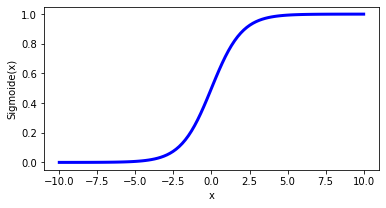

In [5]:
x = np.linspace(-10, 10, 100) 
z = 1/(1 + np.exp(-x)) 

fig = plt.figure(figsize=(6,3)) 
plt.plot(x, z, linewidth=3, color='blue') 
plt.xlabel("x") 
plt.ylabel("Sigmoide(x)") 
#plt.axis('off')
fig.savefig('sigmoide.png', dpi=fig.dpi, transparent=True) 
plt.show() 


# 3. Lectura del dataset

In [ ]:
path = r'/content/drive/Shareddrives/Data Science para Geociencias/6. Métodos de ML/6.2 Regresión Logística'
name = 'weatherAUS.csv'

In [ ]:
raindf = pd.read_csv(os.path.join(path,name))
raindf.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


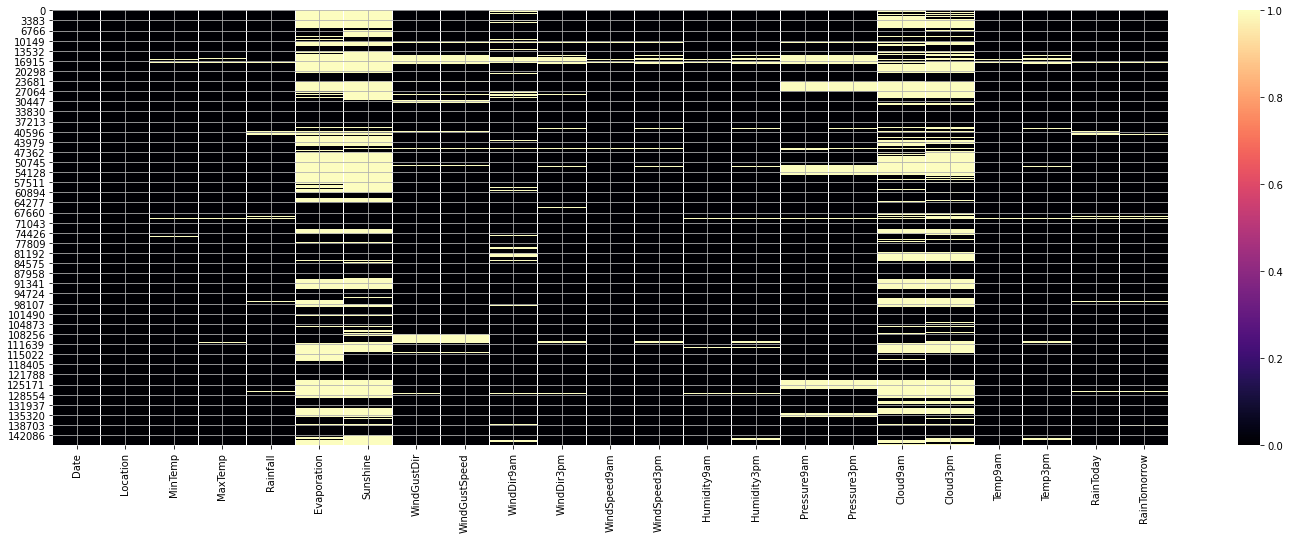

In [ ]:
fig, ax = plt.subplots(figsize=(25,8))
sns.heatmap(raindf.isnull(), ax=ax, cmap="magma")
plt.grid()
plt.show()

# 4. Limpieza de los datos

In [ ]:
raindf.drop(['Date'], axis=1, inplace=True)
raindf['Location'].fillna(raindf['Location'].mode(), inplace=True)

In [ ]:
raindf['MinTemp'].fillna(raindf['MinTemp'].mean(), inplace=True)
raindf['MaxTemp'].fillna(raindf['MaxTemp'].mean(), inplace=True)
raindf['Rainfall'].fillna(raindf['Rainfall'].mean(), inplace=True)
raindf['WindGustDir'].fillna(raindf['WindGustDir'].mode(), inplace=True)
raindf['WindGustSpeed'].fillna(raindf['WindGustSpeed'].mean(), inplace=True)
raindf['WindDir9am'].fillna(raindf['WindDir9am'].mode(), inplace=True)
raindf['WindDir3pm'].fillna(raindf['WindDir3pm'].mode(), inplace=True)
raindf['WindSpeed9am'].fillna(raindf['WindSpeed9am'].mean(), inplace=True)
raindf['WindSpeed3pm'].fillna(raindf['WindSpeed3pm'].mean(), inplace=True)
raindf['Humidity9am'].fillna(raindf['Humidity9am'].mean(), inplace=True)
raindf['Humidity3pm'].fillna(raindf['Humidity3pm'].mean(), inplace=True)
raindf['Pressure9am'].fillna(raindf['Pressure9am'].mean(), inplace=True)
raindf['Pressure3pm'].fillna(raindf['Pressure3pm'].mean(), inplace=True)
raindf['Cloud9am'].fillna(raindf['Cloud9am'].mean(), inplace=True)
raindf['Cloud3pm'].fillna(raindf['Cloud3pm'].mean(), inplace=True)
raindf['Temp9am'].fillna(raindf['Temp9am'].mean(), inplace=True)
raindf['Temp3pm'].fillna(raindf['Temp3pm'].mean(), inplace=True)

In [ ]:
raindf = raindf[raindf.WindDir9am.notnull()]
raindf = raindf[raindf.WindDir3pm.notnull()]
raindf = raindf[raindf.WindGustDir.notnull()]
raindf = raindf[raindf.Evaporation.notnull()]
raindf = raindf[raindf.Sunshine.notnull()]
raindf = raindf[raindf.RainToday.notnull()]
raindf = raindf[raindf.RainTomorrow.notnull()]

In [ ]:
fig, ax = plt.subplots(figsize=(25,8))
sns.heatmap(raindf.isnull(), ax=ax, cmap="magma")
plt.grid()
plt.show()

# 5. Exploración de los datos 

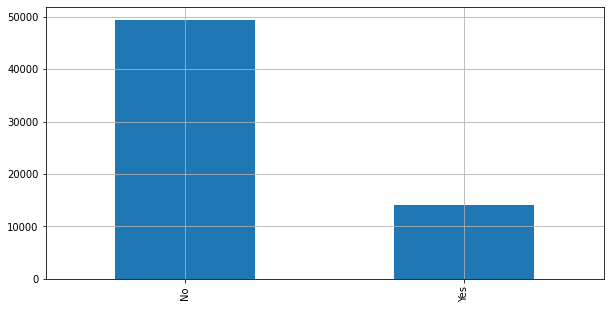

In [ ]:
raindf['RainTomorrow'].value_counts().plot(kind='bar', figsize=(10,5), grid=True)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1150: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


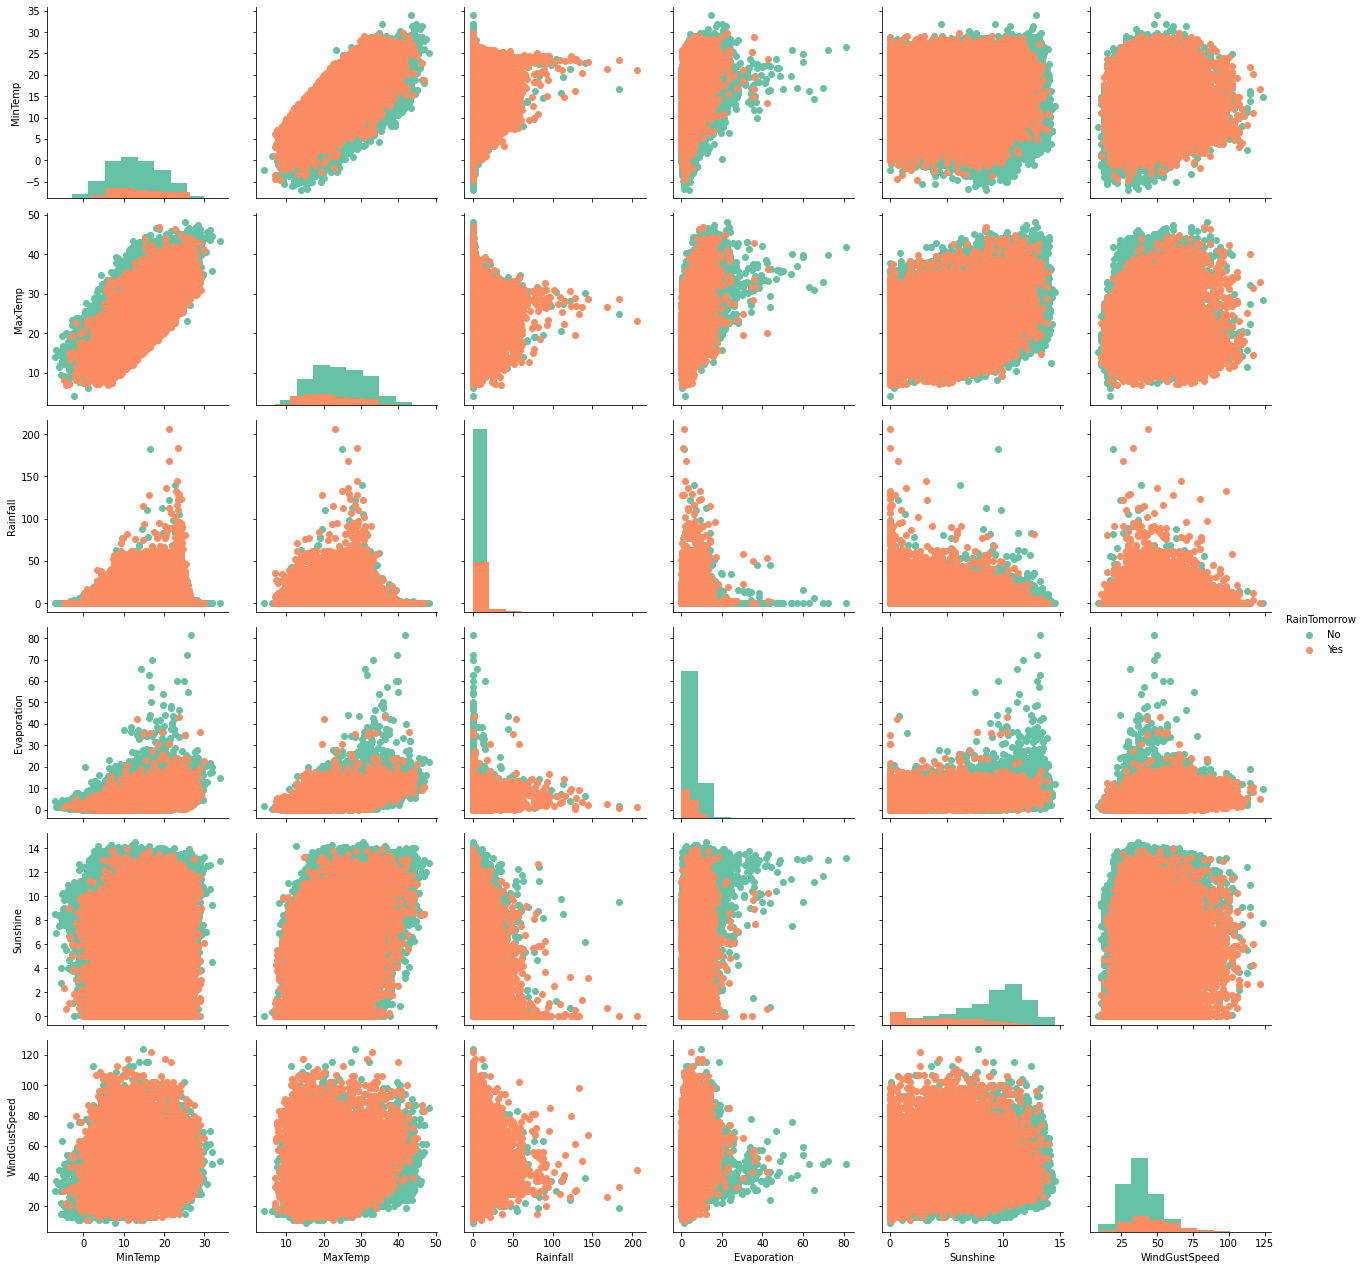

In [ ]:
g = sns.PairGrid(data=raindf, vars=['MinTemp', 'MaxTemp', 'Rainfall',
                                     'Evaporation', 'Sunshine','WindGustSpeed'
                                     ], hue='RainTomorrow', size=3, palette='Set2')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

In [ ]:
raindf.drop_duplicates(keep = False, inplace = True)

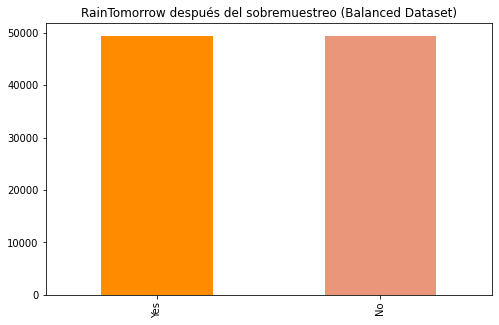

In [ ]:
no = raindf[raindf.RainTomorrow == 'No']
yes = raindf[raindf.RainTomorrow == 'Yes']
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = False).plot(kind='bar', color= ['darkorange','darksalmon'])
plt.title('RainTomorrow después del sobremuestreo (Balanced Dataset)')
plt.show()

In [ ]:
y = oversampled['RainTomorrow']
X = oversampled.drop(['RainTomorrow'], axis=1)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98816 entries, 6049 to 67361
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       98816 non-null  object 
 1   MinTemp        98816 non-null  float64
 2   MaxTemp        98816 non-null  float64
 3   Rainfall       98816 non-null  float64
 4   Evaporation    98816 non-null  float64
 5   Sunshine       98816 non-null  float64
 6   WindGustDir    98816 non-null  object 
 7   WindGustSpeed  98816 non-null  float64
 8   WindDir9am     98816 non-null  object 
 9   WindDir3pm     98816 non-null  object 
 10  WindSpeed9am   98816 non-null  float64
 11  WindSpeed3pm   98816 non-null  float64
 12  Humidity9am    98816 non-null  float64
 13  Humidity3pm    98816 non-null  float64
 14  Pressure9am    98816 non-null  float64
 15  Pressure3pm    98816 non-null  float64
 16  Cloud9am       98816 non-null  float64
 17  Cloud3pm       98816 non-null  float64
 18  Tem

# 6. Codificación y Escalamiento 

In [ ]:
le_loc = LabelEncoder()
X['Location'] = le_loc.fit_transform(X.Location.values)

le_windgustdir = LabelEncoder()
X['WindGustDir'] = le_windgustdir.fit_transform(X.WindGustDir.values)

le_windgustdir = LabelEncoder()
X['WindGustDir'] = le_windgustdir.fit_transform(X.WindGustDir.values)

le_winddir9am = LabelEncoder()
X['WindDir9am'] = le_winddir9am.fit_transform(X.WindDir9am.values)

le_winddir3pm = LabelEncoder()
X['WindDir3pm'] = le_winddir3pm.fit_transform(X.WindDir3pm.values)

le_winddir3pm = LabelEncoder()
X['WindDir3pm'] = le_winddir3pm.fit_transform(X.WindDir3pm.values)

le_raintoday = LabelEncoder()
X['RainToday'] = le_raintoday.fit_transform(X.RainToday.values)

In [ ]:
le_raintomorrow = LabelEncoder()
y = le_raintomorrow.fit_transform(y.values)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
X.loc[:,:] = scaler.fit_transform(X)

In [ ]:
clases = raindf['RainTomorrow'].unique().tolist()
n_clases = len(clases)
print(clases)

['No', 'Yes']


In [ ]:
features = X.columns.tolist()[:-1]
print(features)

['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [ ]:
pesos = [0.5, 0.5]
print(pesos)

[0.5, 0.5]


In [ ]:
X = X.values

# 7. Predicción con regresión logística

In [ ]:
def plot_confusion_matrix(cm, classes, tit, normalize=False):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)
        title, fmt = 'Matriz de confusión normalizada', '.2f'
    else:
        title, fmt = tit, 'd'
    plt.figure(figsize=(6,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)#, fontsize=12)
    plt.colorbar(pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Clase Verdadera')#, fontsize=10)
    plt.xlabel('Clase Predicha')#, fontsize=10)
    plt.savefig(title+'.png')
    plt.grid(False)
    plt.show()

In [ ]:
def sens_spec(cls_names, y_true, y_pred, pesos):
  sensitivity = []
  specificity = []
  prec=[]
  fscore = []
  sd = []
  for i,name in enumerate(cls_names):
    TP = np.sum((y_true==name) & (y_pred==name))
    TN = np.sum((y_true!=name) & (y_pred!=name))
    FP = np.sum((y_true!=name) & (y_pred==name))
    FN = np.sum((y_true==name) & (y_pred!=name))
    sensitivity.append(TP/(TP+FN))
    specificity.append(FP/(TN+FP))
    prec.append(TP/(TP+FP))
    fscore.append(2*(prec[i]*sensitivity[i])/(prec[i]+sensitivity[i]))
  sensitivity.append(sum([x*y for x,y in zip(sensitivity,pesos)]))
  specificity.append(sum([x*y for x,y in zip(specificity,pesos)]))
  prec.append(sum([x*y for x,y in zip(prec,pesos)]))
  fscore.append(sum([x*y for x,y in zip(fscore,pesos)]))
  for i in range(len(cls_names)):
    sd.append(np.sqrt((sensitivity[i]-sensitivity[-1])**2))
  sd.append(np.nan)
  return sensitivity, specificity, prec, fscore, sd

In [ ]:
logreg = LogisticRegression(solver='newton-cg', max_iter=200)
kfold = KFold(n_splits=10, shuffle=True)

In [ ]:
score = cross_val_score(logreg, X, y, cv=kfold, scoring="accuracy")
print(score)

[0.79396883 0.79467719 0.80115361 0.80024287 0.79568913 0.80914795
 0.80072867 0.79789495 0.8036636  0.80163951]


In [ ]:
y_pred = cross_val_predict(logreg, X, y, cv=10)

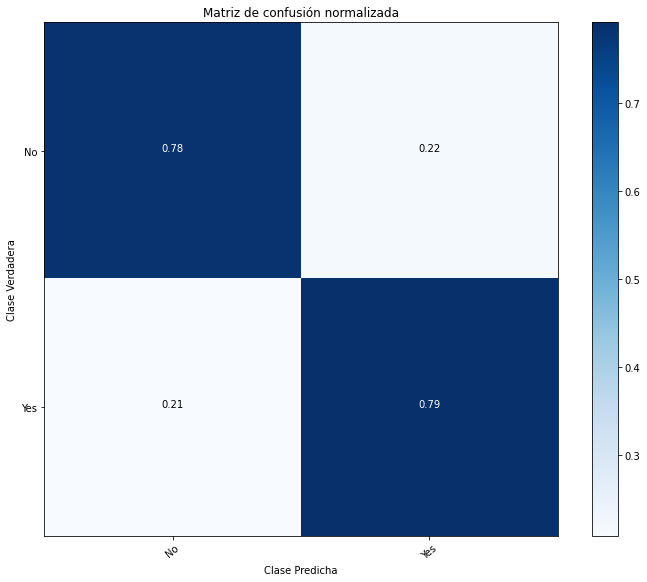

In [ ]:
predictions = np.float32(y_pred)
true_labels = np.float32(y)
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(2))
tit = 'Matriz de confusión Regreesión Logística'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=True)

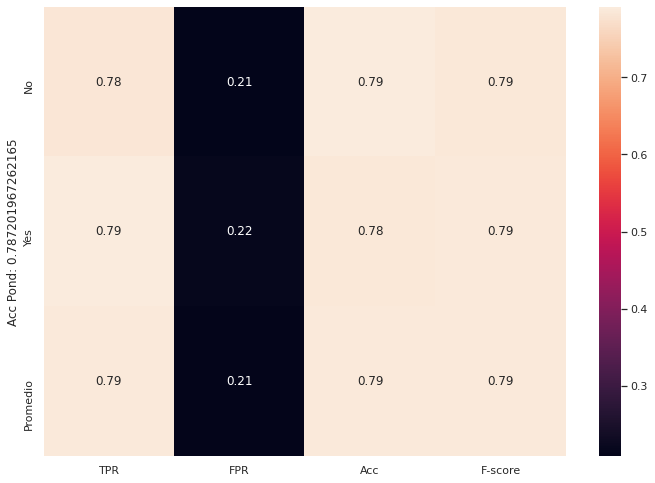

In [ ]:
sensitivity, FPR, prec, fscore, sd = sens_spec(range(2), true_labels, predictions, pesos)
d = {'TPR':sensitivity, 'FPR':FPR, 'Acc':prec, 'F-score':fscore}
ind = clases+['Promedio']
df = pd.DataFrame(d, index=ind)#.transpose()
index = df.index
precprom = sum([x*y for x,y in zip(prec,pesos)])
index.name = 'Acc Pond: %s'%precprom
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)